# **Analysis of orbital experiments**

In this notebook, we will perform some simple data manipulation and become familiar with plotting maps and time series. For each section, describe your result(s) and think about what analysis you can do to explain them (*hint: see guiding questions*).

Import packages

In [1]:
import os, sys, iris
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import iris.plot as iplt
import iris.coord_categorisation
import iris.analysis.cartography
#from iris.experimental.equalise_cubes import equalise_attributes
from scipy.stats import ttest_ind

Some helpful functions

In [2]:
# Add coords to time dimension to allow aggregation
def add_time_coords(cube,time_cf_standard_name = 'time'):
    iris.coord_categorisation.add_season(cube,time_cf_standard_name)
    return cube

# Convert precipitation flux to mm/day
def convert_precip_flux_units(cube):
    cube.data = cube.data * 24.
    cube.units = 'mm/day'
    return cube

# Convert specific humidity to g/kg
def convert_q_units(cube):
    cube.data = cube.data * 1000.
    cube.units = 'g/kg'
    return cube

# Find nearest value in array
def find_nearest(array,value):
    idx = (abs(array-value)).argmin()
    return array[idx]

# Find sigma layer approximately corresponding to given pressure level
def approximate_sigma_layer(p_lev,cube):
    global_mean_surface_pressure = 1013.    #hPa
    ratio = float(p_lev)/global_mean_surface_pressure
    sigma_layer = find_nearest(cube.coord('sigma layer').points,ratio)
    sigma_layer_idx = cube.coord('sigma layer').points.tolist().index(sigma_layer)
    return sigma_layer, sigma_layer_idx

Specify experiments (control and peturbed simulation), the data output path, and where to save figures

In [3]:
data_dir = '/home/users/bakera/NCAS/CMSS2025/'

ctlID = 'control_0001'  # Control simulation
ptbID = 'orbital_half_tilt_0001'  # Peturbed simulation

plot_dir = os.path.join(data_dir,'plots/','run_'+ptbID)
if not os.path.isdir(plot_dir):
    os.makedirs(plot_dir)
    print('created {}/'.format(plot_dir))

Output units and data constraints

In [4]:
units = dict(
    st = 'Celsius',
    precip_cond_rate = 'mm/day',
    u = 'm/s',
    vor = 's-1')

seasons = ['djf','mam','jja','son']
CONSTRAINTS = dict()
for season in seasons:
    CONSTRAINTS[season] = iris.Constraint(season=season)

Load soil temperature (proxy for surface temperature) and large-scale precipitation rate output

In [5]:
# Load soil temperature and large-scale precipitation flux fields into iris cubes
var_names = ['st','precip_cond_rate']
grid_coords = ['latitude','longitude']
st_lev = 0

PTB = dict()
CTL = dict()
for var_name in var_names:
    PTB[var_name] = dict()
    CTL[var_name] = dict()
    
    # Sub-directories
    ptb_dir = os.path.join(data_dir,'run_'+ptbID)
    ctl_dir = os.path.join(data_dir,'run_'+ctlID)
    fn = 'output.nc'
    ptb_ffp = os.path.join(ptb_dir,fn)
    ctl_ffp = os.path.join(ctl_dir,fn)
    ptb_cube = iris.load_cube(ptb_ffp,var_name)
    ctl_cube = iris.load_cube(ctl_ffp,var_name)
    add_time_coords(ptb_cube)
    add_time_coords(ctl_cube)
    if var_name == 'st':
        PTB[var_name] = ptb_cube[:,st_lev]
        CTL[var_name] = ctl_cube[:,st_lev]
    else:
        PTB[var_name] = ptb_cube
        CTL[var_name] = ctl_cube
    
    # Convert units
    unit = units[var_name]
    if PTB[var_name].units.origin != unit:
        PTB[var_name].convert_units(unit)
    if CTL[var_name].units.origin != unit:
        CTL[var_name].convert_units(unit)

print('done.')

done.


Plot climatology and response maps

/tmp/ipykernel_3418/988749285.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  c_map = cm.get_cmap('RdBu_r'),
/tmp/ipykernel_3418/988749285.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  c_map_diff = cm.get_cmap('RdBu_r'),
/tmp/ipykernel_3418/988749285.py:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  c_map = cm.get_cmap('YlGnBu'),
/tmp/ipykernel_3418/988749285.py:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be 

CLIMATOLOGY_orbital_half_tilt_0001_global_st_P.pdf saved.


<Figure size 640x480 with 0 Axes>

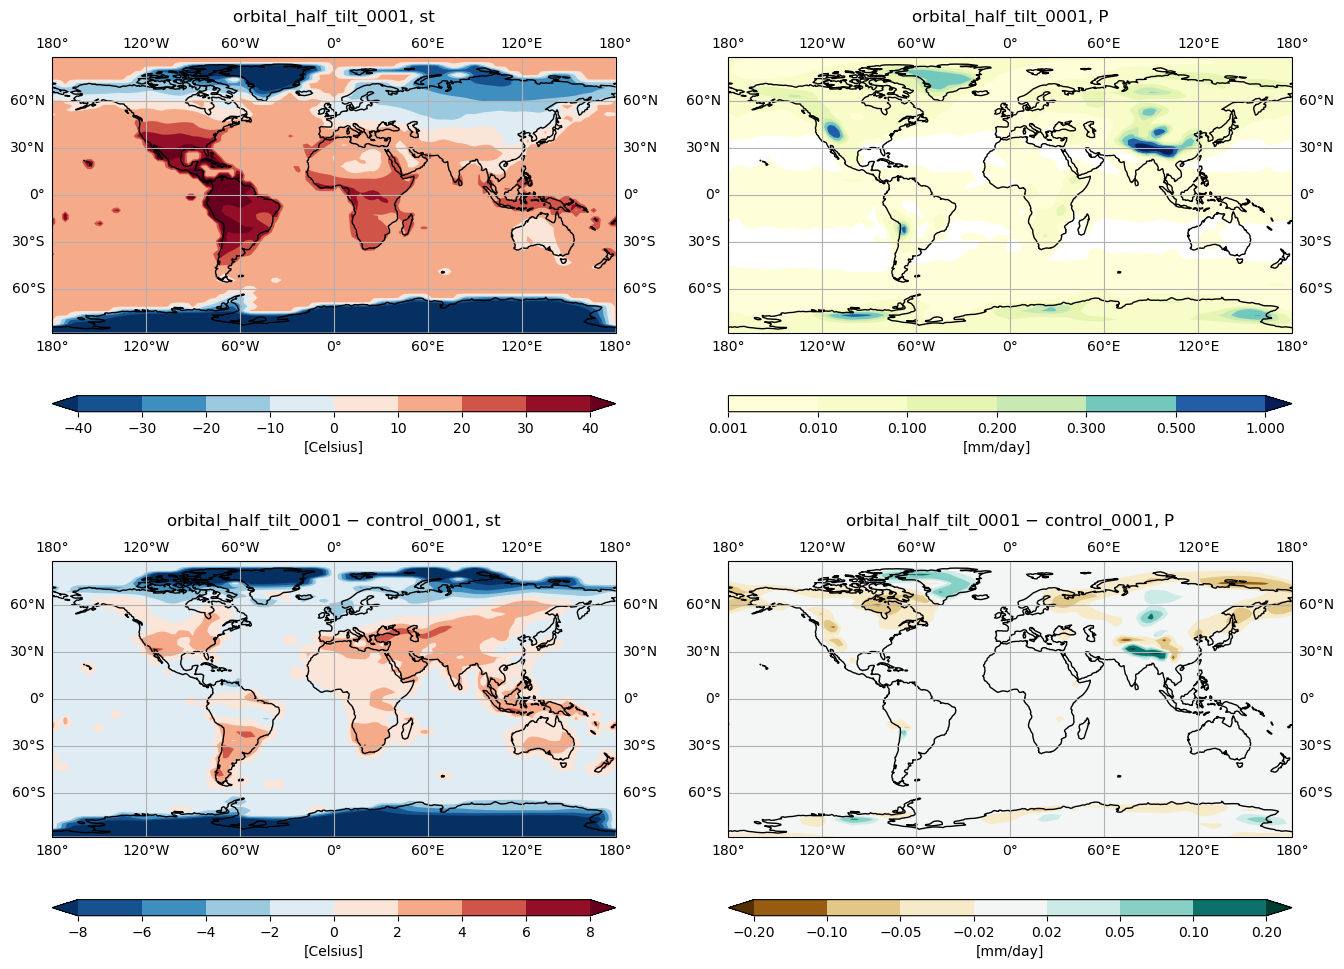

In [6]:
# Options
save_plot = True

domain = False  # cut out a region if True; global if False
domain_name = 'Atlantic'
lat_limits = (-15,75)
lon_limits = (-140,40)


# Plot setup
plt.clf()
figure, axes = plt.subplots(nrows=2, ncols=2, figsize=(16,12))

PLOTTING = dict(
    st = dict(
        title = 'st',
        c_map = cm.get_cmap('RdBu_r'),
        c_map_diff = cm.get_cmap('RdBu_r'),
        ext = 'both',
        cmap_levels = np.arange(-40,41,10),
        cmap_levels_diff = np.arange(-8,9,2),
        tick_levels = np.arange(-40,41,10),
        tick_levels_diff = np.arange(-8,9,2)),
    precip_cond_rate = dict(
        title = 'P',
        c_map = cm.get_cmap('YlGnBu'),
        c_map_diff = cm.get_cmap('BrBG'),
        ext = 'max',
        cmap_levels = [0.001,0.01,0.1,0.2,0.3,0.5,1],
        cmap_levels_diff = [-0.2,-0.1,-0.05,-0.02,0.02,0.05,0.1,0.2],
        tick_levels = [0.001,0.01,0.1,0.2,0.3,0.5,1],
        tick_levels_diff = [-0.2,-0.1,-0.05,-0.02,0.02,0.05,0.1,0.2]))


# Make figure
for var_name in var_names:
    # Annual mean
    ptb_annual_mean = PTB[var_name].collapsed('time',iris.analysis.MEAN)
    ctl_annual_mean = CTL[var_name].collapsed('time',iris.analysis.MEAN)
    
    # Response
    response = ptb_annual_mean - ctl_annual_mean
    if domain:
        response = response.intersection(longitude=lon_limits, latitude=lat_limits)
    
    # Plot map
    plt.subplot(2,2,var_names.index(var_name)+1)
    con1 = iplt.contourf(ptb_annual_mean,
                         PLOTTING[var_name]['cmap_levels'], extend=PLOTTING[var_name]['ext'],
                         cmap=PLOTTING[var_name]['c_map'])
    cbar = plt.colorbar(con1, orientation='horizontal', aspect=35)
    cbar.set_label('[{}]'.format(units[var_name]))
    cbar.set_ticks(PLOTTING[var_name]['tick_levels'])
    fig = plt.gca()
    fig.coastlines()
    fig.gridlines(draw_labels=True)
    fig.set_title(ptbID+', '+PLOTTING[var_name]['title'], y=1.1)  # y specifies title offset
    
    plt.subplot(2,2,var_names.index(var_name)+3)
    con2 = iplt.contourf(response,
                         PLOTTING[var_name]['cmap_levels_diff'], extend='both',
                         cmap=PLOTTING[var_name]['c_map_diff'])
    cbar = plt.colorbar(con2, orientation='horizontal', aspect=35)
    cbar.set_label('[{}]'.format(units[var_name]))
    cbar.set_ticks(PLOTTING[var_name]['tick_levels_diff'])
    fig = plt.gca() 
    fig.coastlines()
    fig.gridlines(draw_labels=True)
    fig.set_title(ptbID+r' $-$ '+ctlID+', '+PLOTTING[var_name]['title'], y=1.1)


# Save figure
if save_plot:
    if not domain:
        domain_name = 'global'
    plot_fname = '_'.join(['CLIMATOLOGY',ptbID,domain_name,
                          '_'.join([PLOTTING[var_name]['title'] for var_name in var_names])])+'.pdf'
    plt.savefig(os.path.join(plot_dir,plot_fname))
    print(plot_fname+' saved.')
plt.show()

Plot seasonal timeseries

/opt/jaspy/lib/python3.11/site-packages/iris/analysis/cartography.py:436: IrisDefaultingWarning: Using DEFAULT_SPHERICAL_EARTH_RADIUS.
  warnings.warn(
/opt/jaspy/lib/python3.11/site-packages/iris/analysis/cartography.py:436: IrisDefaultingWarning: Using DEFAULT_SPHERICAL_EARTH_RADIUS.
  warnings.warn(


TIMESERIES_orbital_half_tilt_0001_global_st_P.pdf saved.


<Figure size 640x480 with 0 Axes>

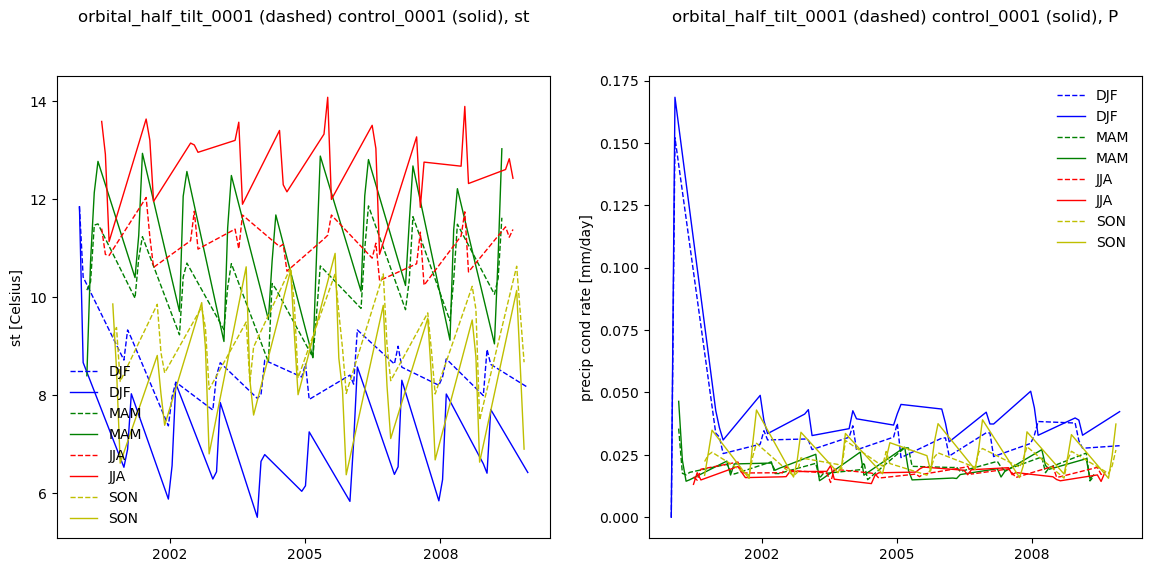

In [7]:
# Options
save_plot = True

domain = False  # cut out a region if True; global if False
domain_name = 'Atlantic'
lat_limits = (-15,75)
lon_limits = (-140,40)


# Plot setup
plt.clf()
figure, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,6))

plot_colours = dict(
    djf = 'b',
    mam = 'g',
    jja = 'r',
    son = 'y')


# Make figure
for var_name in var_names:
    plt.subplot(1,2,var_names.index(var_name)+1)
    
    # Domain, grid, and area average
    for l in grid_coords:
        if not PTB[var_name].coord(l).has_bounds():
            PTB[var_name].coord(l).guess_bounds()
        if not CTL[var_name].coord(l).has_bounds():
            CTL[var_name].coord(l).guess_bounds()
    area_weights_ptb = iris.analysis.cartography.area_weights(PTB[var_name])
    area_weights_ctl = iris.analysis.cartography.area_weights(CTL[var_name])
    ptb_area_mean = PTB[var_name].collapsed(grid_coords, iris.analysis.MEAN, weights=area_weights_ptb)
    ctl_area_mean = CTL[var_name].collapsed(grid_coords, iris.analysis.MEAN, weights=area_weights_ctl)
    if domain:
        ptb_area_mean = ptb_area_mean.intersection(longitude=lon_limits, latitude=lat_limits)
        ctl_area_mean = ctl_area_mean.intersection(longitude=lon_limits, latitude=lat_limits)
        
    # Extract, plot seasonal responses
    for season in seasons:
        ptb_area_mean_seas = ptb_area_mean.extract(CONSTRAINTS[season])
        ctl_area_mean_seas = ctl_area_mean.extract(CONSTRAINTS[season])
        
        iplt.plot(ptb_area_mean_seas,
                  color=plot_colours[season], ls='dashed', lw=1., label=season.upper())
        iplt.plot(ctl_area_mean_seas,
                  color=plot_colours[season], ls='solid', lw=1., label=season.upper())
    plt.gca().set_title(ptbID+' (dashed) '+ctlID+' (solid), '+PLOTTING[var_name]['title'], y=1.1)
    plt.ylabel(var_name.replace('_',' ')+' [{}]'.format(units[var_name]))
    plt.legend(loc='best', prop=dict(size=10), frameon=False)


# Save figure
if save_plot:
    if not domain:
        domain_name = 'global'
    plot_fname = '_'.join(['TIMESERIES',ptbID,domain_name,
                          '_'.join([PLOTTING[var_name]['title'] for var_name in var_names])])+'.pdf'
    plt.savefig(os.path.join(plot_dir,plot_fname))
    print(plot_fname+' saved.')
plt.show()

Examine the jet streams

/opt/jaspy/lib/python3.11/site-packages/iris/coords.py:2154: IrisVagueMetadataWarning: Cannot check if coordinate is contiguous: Invalid operation for 'time', with 0 bound(s). Contiguous bounds are only defined for 1D coordinates with 2 bounds. Metadata may not be fully descriptive for 'time'. Ignoring bounds.
  warnings.warn(
/opt/jaspy/lib/python3.11/site-packages/iris/coords.py:2154: IrisVagueMetadataWarning: Cannot check if coordinate is contiguous: Invalid operation for 'longitude', with 0 bound(s). Contiguous bounds are only defined for 1D coordinates with 2 bounds. Metadata may not be fully descriptive for 'longitude'. Ignoring bounds.
  warnings.warn(
/opt/jaspy/lib/python3.11/site-packages/iris/coords.py:2154: IrisVagueMetadataWarning: Cannot check if coordinate is contiguous: Invalid operation for 'time', with 0 bound(s). Contiguous bounds are only defined for 1D coordinates with 2 bounds. Metadata may not be fully descriptive for 'time'. Ignoring bounds.
  warnings.warn(
/op

JET_STREAM_orbital_half_tilt_0001_global.pdf saved.


<Figure size 640x480 with 0 Axes>

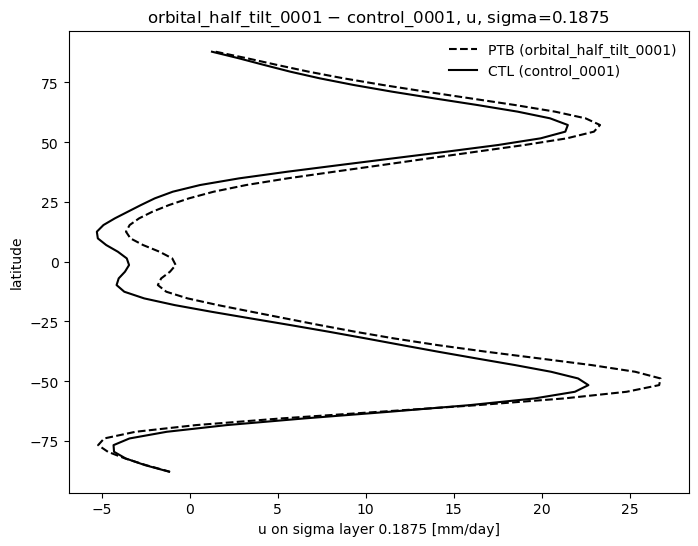

In [8]:
# Options
save_plot = True

var_name = 'u'
p_lev = 250  # desired pressure level in hPa


# Load wind data
ptb_dir = os.path.join(data_dir,'run_'+ptbID)
ctl_dir = os.path.join(data_dir,'run_'+ctlID)
fn = 'output.nc'
ptb_ffp = os.path.join(ptb_dir,fn)
ctl_ffp = os.path.join(ctl_dir,fn)
ptb_cube = iris.load_cube(ptb_ffp,var_name)
ctl_cube = iris.load_cube(ctl_ffp,var_name)
add_time_coords(ptb_cube)
add_time_coords(ctl_cube)

sigma_layer, sigma_layer_idx = approximate_sigma_layer(250,ctl_cube)

PTB[var_name] = ptb_cube[:,sigma_layer_idx]
CTL[var_name] = ctl_cube[:,sigma_layer_idx]

# Compute latitudinal time-mean profiles
ptb_mean = PTB[var_name].collapsed(['longitude','time'], iris.analysis.MEAN)
ctl_mean = CTL[var_name].collapsed(['longitude','time'], iris.analysis.MEAN)

# Plot figure
plt.clf()
figure, axes = plt.subplots(nrows=1, ncols=1, figsize=(8,6))

latitudes = ctl_cube.coord('latitude').points
title = ', '.join([ptbID+r' $-$ '+ctlID,var_name,'sigma='+str(sigma_layer)])

plt.subplot(1,1,1)
plt.plot(ptb_mean.data, latitudes, color='k', ls='dashed', lw=1.5, label='PTB ({})'.format(ptbID))
plt.plot(ctl_mean.data, latitudes, color='k', ls='solid', lw=1.5, label='CTL ({})'.format(ctlID))
plt.xlabel('u on sigma layer {} [{}]'.format(sigma_layer,unit))
plt.ylabel('latitude')
plt.gca().set_title(title)
plt.legend(loc='best', prop=dict(size=10), frameon=False)


# Save figure
if save_plot:
    domain_name = 'global'
    plot_fname = '_'.join(['JET_STREAM',ptbID,domain_name])+'.pdf'
    plt.savefig(os.path.join(plot_dir,plot_fname))
    print(plot_fname+' saved.')
plt.show()